Michelle 2/28/19

Replacement of Pigeon.jl w/o ROS requirements

Suitable for Collision Avoidance Controller using HJI severity

In [5]:
using LinearAlgebra
using Distributed
using StaticArrays
using DifferentialDynamicsModels
using LinearDynamicsModels
using ForwardDiff
using Interpolations
using OSQP.MathOptInterfaceOSQP
using OSQP
import MathOptInterface
const MOI = MathOptInterface
using Parametron
using JLD2
using Plots
import StaticArrays: SUnitRange
import DifferentialDynamicsModels: mod2piF, adiff
import Interpolations: GriddedInterpolation, Extrapolation
Parametron.Parameter(A::AbstractArray, model) = Parameter(identity, A, model)

include("math.jl")
include("vehicles.jl")
include("vehicle_dynamics.jl")
include("HJI_computation.jl")
include("HJI_Human.jl")
include("HJI_Wall.jl")
include("trajectories.jl")
include("model_predictive_control.jl")
# include("decoupled_lat_long.jl")
# include("coupled_lat_long.jl")
include("joint_traj_tracking.jl")


get_next_control (generic function with 2 methods)

In [6]:
# Define trajectory 
trajectory = straight_trajectory(30., 8.) #(len, vel) # travel East (x)

# Construct Trajectory-tracking Coupled MPC
robotMPC = JointTrajectoryTrackingMPC(X1(), trajectory, N_short=5, N_long=10)

# Loading HJI Cache
const HJI_cache_dist = HJICache(joinpath(@__DIR__, "../deps/BicycleCAvoid.jld2"));
const HJI_cache_human = load_HJICache_Human(joinpath(@__DIR__, "../deps/HJIValue_Human_MinD.jld2"));
const HJI_cache_wall = load_HJICache_Wall(joinpath(@__DIR__, "../deps/HJIValue_Wall.jld2"));
robotMPC.HJI_cache_human = HJI_cache_human;
robotMPC.HJI_cache_wall = HJI_cache_wall;
robotMPC.HJI_cache_dist = HJI_cache_dist;


In [11]:
# Initial States
robotMPC.current_state = BicycleState(0., 0., -pi/2, 9., 0., 0.) #(X, Y, th, Ux, Uy, yawrate)
robotMPC.current_control = BicycleControl(0., 0., 0.) #(δ, Fxf, Fxr)
robotMPC.other_car_state = SimpleCarState(10., -3.6, deg2rad(10), 4.) #(X, Y, th, V)
robotMPC.wall_state = 3.6

# Construct relative states
relative_state = HJIRelativeState_Human(robotMPC.current_state, robotMPC.other_car_state) #(ΔX, ΔY, θr, θh Ux)

# Extract Value
V, ∇V = robotMPC.HJI_cache_human[relative_state]

#optimal control
u_star = optimal_control(robotMPC.dynamics, relative_state, ∇V)

2-element BicycleControl2{Float64}:
    -1.0471975511965976
 -6874.0               

In [ ]:
_, _, t = path_coordinates(robotMPC.trajectory, robotMPC.current_state)
compute_time_steps!(robotMPC, t)
compute_linearization_nodes!(robotMPC)
update_QP!(robotMPC)
solve!(robotMPC)


In [ ]:
s, e, _ = path_coordinates(robotMPC.trajectory, robotMPC.current_state)
u_next = get_next_control(robotMPC)
# xs = robotMPC.qs[1]

In [12]:
qs, qhs, xs, us, ps = simulate(robotMPC, robotMPC.current_state, robotMPC.current_control);

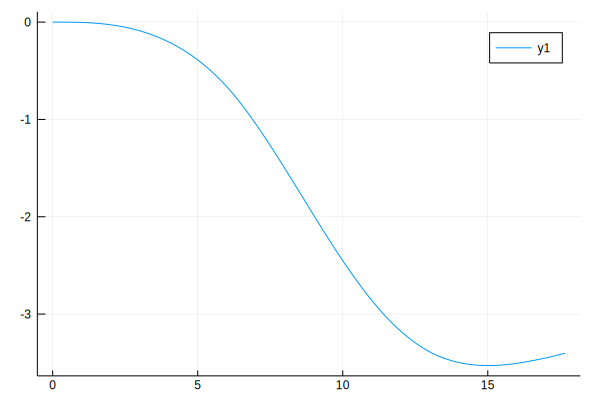

In [13]:
E = []
N = []
for i = 1:370
    push!(E, qs[i][1])
    push!(N, qs[i][2])
end
plot(E, N)

In [ ]:
u1 = []
u2 = []
for i = 1:375
    push!(u1, us[i][1])
    push!(u2, us[i][2]/1964)
end
plot(u1)
plot!(u2)

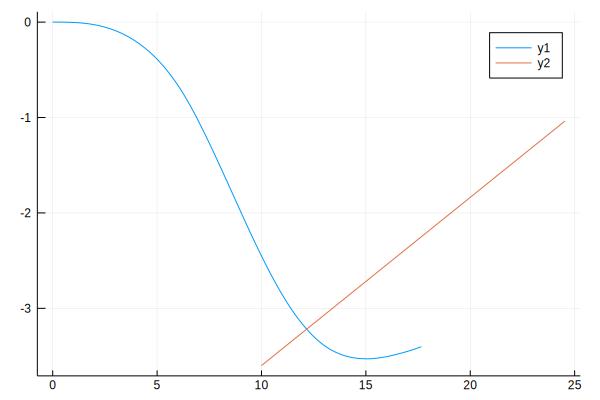

In [14]:
Eh = []
Nh = []
for i = 1:370
    push!(Eh, qhs[i][1])
    push!(Nh, qhs[i][2])
end

plot!(Eh, Nh)

In [ ]:
for i = 1:375
    print(HJIRelativeState_Human(qs[i], qhs[i]), "\n")
end